In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import wrf
from analysis_dependencies import get_wrf_slp
from analysis_dependencies import gen_cartopy_proj
from analysis_dependencies import get_wrf_kinematic
import datetime

In [2]:
# internal functions:
#
# haversine_np: compute the distance between 2 (lat,lon) points, or between
# a vector of (lat,lon) points and a single point. Uses great-circle distance
# estimated from Haversine function using the WRF's approximation of the Earth
# sphere to define radius.
#
# INPUTS:
#
# lat1: starting latitude (deg)
# lon1: starting longitude (deg)
# lat2: ending latitude (deg)
# lon2: ending longitude (deg)
#
# NOTE: either (lat1,lon1) can be a vector or array of points, or (lat2,lon2),
#       but not both. One of these sets has to be a scalar to compute the distance
#       to a single point for all points in the vector/array set.
#
# OUTPUTS:
#
# km: distance (km, assuming Earth is a sphere of 6370 km radius)
#
# DEPENDENCIES:
#
# numpy
def haversine_np(lat1, lon1, lat2, lon2):
    import numpy as np
    # assert all (lat,lon) values as radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # compute delta-(lat,lon) between points 1 and 2
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # Haversine equation for unit sphere
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # scale to Earth approx. radius
    km = 6370 * c  # using same km radius as WRF earth-approximation
    return km


# compute_outflow_profile: Generates a vertical profile in native (sigma) coordinates of
# the summed divergence within a chosen radius of a chosen grid-point.
#
# INPUTS:
#
# wrfHDL: netCDF4.Dataset() file-handle of WRF file
# jCen: j value in 2D [j,i]-space to center the radius
# iCen: i value in 2D [j,i]-space to center the radius
# radMin: minimum radius from [j,i] point to sum divergence (km)
# radMax: maximum radius from [j,i] point to sum divergence (km)
#
# OUTPUTS:
#
# divProf: profile of summed divergence between radMin and radMax radii of point [jCen,iCen]
#
# DEPENDENCIES:
#
# numpy
# netCDF4.Dataset()
# analysis_dependencies.get_wrf_kinematic()
# haversine_np
def compute_outflow_profile(wrfHDL, jCen, iCen, radMin=0., radMax=400.):
    import numpy as np
    from netCDF4 import Dataset
    from analysis_dependencies import get_wrf_kinematic
    # pull latitude and longitude from wrfHDL
    lat = np.asarray(unpHdl.variables['XLAT']).squeeze()
    lon = np.asarray(unpHdl.variables['XLONG']).squeeze()
    fix = np.where(lon < 0.)
    lon[fix] = lon[fix] + 360.
    # pull divergence from wrfHDL
    div = np.asarray(get_wrf_kinematic(wrfHDL,'div')).squeeze()
    # compute distance of all 2D [j,i]-space points from jCen, iCen
    dist = haversine_np(lat,lon,lat[jCen,iCen],lon[jCen,iCen])
    # find all 2D [j,i]-space points within radMin and radMax of center-point 
    inRad = np.where((dist.flatten() >= radMin) & (dist.flatten() <= radMax))
    # define divProf as NaN vector and fill with summed divergence on each level
    divProf = np.nan * np.ones((np.shape(div)[0],))
    for k in range(np.size(divProf)):
        dk = np.asarray(div[k,:,:].squeeze())
        divProf[k] = np.nansum(dk.flatten()[inRad])  # np.nansum() used b/c kinematics are NaN on boundaries
    # return
    return divProf

In [5]:
# define resolution subdirectory
res = '9km_res'
# define data directories
unpDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/Ida2021/R_mu/unperturbed/' + res + '/'
ptdDir = '/home/bhoover/UWAOS/WRF_QOIP/data_repository/final_runs/Ida2021/R_mu/negative/uvTq/upper_troposphere/ptdi13/' + res + '/'
# define initial datetime
dtInit = datetime.datetime(2021, 8, 28, 18)
# define all forecast hours
fcstHrs = [0, 3, 6, 9, 12, 15, 18, 21, 24]
# initialize empty lists for divergence profiles
unpDivProfs = []
ptdDivProfs = []
# loop over forecast hours
for fcstHr in fcstHrs:
    print('processing forecast hour {:d} ...'.format(fcstHr))
    # define forecast datetime
    dtFcst = dtInit + datetime.timedelta(hours=fcstHr)
    dtFcstStr = datetime.datetime.strftime(dtFcst,'%Y-%m-%d_%H:00:00')
    # define unperturbed and perturbed wrfout file-names
    unpFile = unpDir + 'wrfout_d01_' + dtFcstStr
    ptdFile = ptdDir + 'wrfout_d01_' + dtFcstStr
    # define netCDF4.Dataset() file-handles
    unpHdl = Dataset(unpFile)
    ptdHdl = Dataset(ptdFile)
    # define SLP field
    unpSLP = np.asarray(get_wrf_slp(unpHdl)).squeeze()
    ptdSLP = np.asarray(get_wrf_slp(ptdHdl)).squeeze()
    # define (j,i) of minimum SLP
    # unperturbed
    ji_min = np.unravel_index(np.argmin(unpSLP), np.shape(unpSLP))
    ji_min = np.asarray(ji_min)
    ju, iu = ji_min
    # perturbed
    ji_min = np.unravel_index(np.argmin(ptdSLP), np.shape(ptdSLP))
    ji_min = np.asarray(ji_min)
    jp, ip = ji_min
    # compute outflow profile
    unpDivProfs.append(compute_outflow_profile(unpHdl, ju, iu, 400., 800.))
    ptdDivProfs.append(compute_outflow_profile(ptdHdl, jp, ip, 400., 800.))
    # Compute net divergence in column of 400 km radius from TC center, this is the radius in which
    # an idealized hurricane with no external, environmental influence on outflow will develop its
    # outflow, as per Ooyama (1987): numerical experiments of steady and transient jets with a simple
    # model of the hurricane outflow, AMS 17th Conf. Tropical Meteor.
    
    

processing forecast hour 0 ...
processing forecast hour 3 ...
processing forecast hour 6 ...
processing forecast hour 9 ...
processing forecast hour 12 ...
processing forecast hour 15 ...
processing forecast hour 18 ...
processing forecast hour 21 ...
processing forecast hour 24 ...


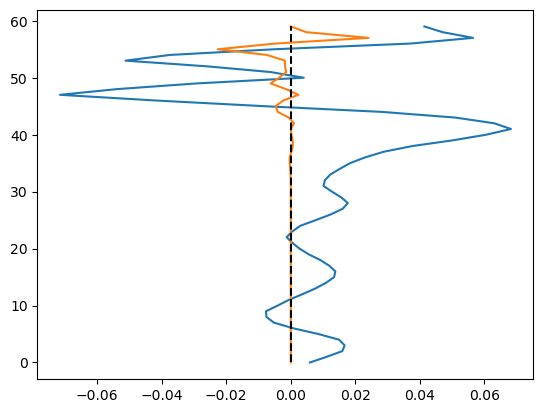

In [6]:
for i in [0]:#range(np.size(fcstHrs)):
    uprof = unpDivProfs[i]
    pprof = ptdDivProfs[i]
    plt.plot(uprof,np.arange(np.size(uprof)))
    plt.plot(pprof-uprof,np.arange(np.size(uprof)))
    plt.plot(np.zeros(np.size(uprof)),np.arange(np.size(uprof)),'--k')
plt.show()

In [6]:
uprof

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

In [4]:
# define forecast datetime
dtFcst = dtInit + datetime.timedelta(hours=fcstHr)
dtFcstStr = datetime.datetime.strftime(dtFcst,'%Y-%m-%d_%H:00:00')
# define unperturbed and perturbed wrfout file-names
unpFile = unpDir + 'wrfout_d01_' + dtFcstStr
ptdFile = ptdDir + 'wrfout_d01_' + dtFcstStr
# define netCDF4.Dataset() file-handles
unpHdl = Dataset(unpFile)
ptdHdl = Dataset(ptdFile)

In [5]:
# define SLP field
unpSLP = np.asarray(get_wrf_slp(unpHdl)).squeeze()
ptdSLP = np.asarray(get_wrf_slp(ptdHdl)).squeeze()

In [6]:
# define (j,i) of minimum SLP
# unperturbed
ji_min=np.unravel_index(np.argmin(unpSLP),np.shape(unpSLP))
ji_min=np.asarray(ji_min)
ju,iu = ji_min
print('j:',ju,'i:',iu,'slp:',unpSLP[ju,iu])
# perturbed
ji_min=np.unravel_index(np.argmin(ptdSLP),np.shape(ptdSLP))
ji_min=np.asarray(ji_min)
jp,ip = ji_min
print('j:',jp,'i:',ip,'slp:',ptdSLP[jp,ip])

j: 124 i: 88 slp: 957.4164955036546
j: 122 i: 87 slp: 980.2483856075311


In [7]:
# compute outflow profile
unpNetDiv = compute_outflow_profile(unpHdl, ju, iu, 0., 400.)
ptdNetDiv = compute_outflow_profile(ptdHdl, jp, ip, 0., 400.)

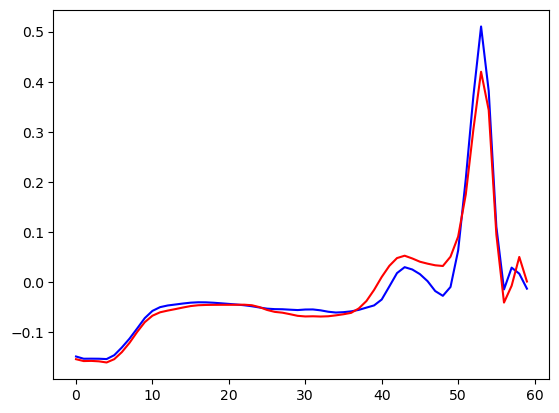

In [8]:
plt.plot(unpNetDiv,'b')
plt.plot(ptdNetDiv,'r')
plt.show()